In [96]:
import pandas as pd
import torch

In [102]:
df = pd.read_csv('./data/train.csv')
smiles_list = df['SMILES'].sample(frac=0.1).tolist()

In [103]:
# Tokenize SMILES strings (character-level )

from collections import Counter

def tokenize(smiles):
    return list(smiles)  # character-level

tokens = [token for s in smiles_list for token in tokenize(s)]
vocab = ['<pad>', '<bos>', '<eos>', '<unk>'] + sorted(set(tokens))
stoi = {ch: i for i, ch in enumerate(vocab)}
itos = {i: ch for ch, i in stoi.items()}

In [99]:
MAX_LEN = 60

def encode(smiles):
    tokens = ['<bos>'] + tokenize(smiles) + ['<eos>']
    idxs = [stoi.get(t, stoi['<unk>']) for t in tokens]
    idxs = idxs[:MAX_LEN] + [stoi['<pad>']] * (MAX_LEN - len(idxs))
    return idxs

input_tensor = torch.tensor([encode(s) for s in smiles_list])

In [100]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, latent_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=3, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        x = self.embedding(x)
        _, (h, _) = self.lstm(x)
        h = h[-1]  # last layer hidden state
        return self.fc_mu(h), self.fc_logvar(h)
    
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim, hidden_dim, latent_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, num_layers=3, batch_first=True)
        self.out = nn.Linear(hidden_dim, vocab_size)

    def forward(self, z, x):
        h = torch.tanh(self.fc(z)).unsqueeze(0)
        c = torch.zeros_like(h)
        x = self.embedding(x)
        output, _ = self.lstm(x, (h, c))
        return self.out(output)
    
class VAE(nn.Module):
    def __init__(self, vocab_size, emb_dim=128, hidden_dim=512, latent_dim=64):
        super().__init__()
        self.encoder = Encoder(vocab_size, emb_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(vocab_size, emb_dim, hidden_dim, latent_dim)

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = reparameterize(mu, logvar)
        x_recon = self.decoder(z, x[:, :-1])  # teacher forcing
        return x_recon, mu, logvar
    
def vae_loss(recon_logits, x, mu, logvar):
    recon_loss = nn.CrossEntropyLoss(ignore_index=stoi['<pad>'])(recon_logits.view(-1, recon_logits.size(-1)), x[:, 1:].contiguous().view(-1))
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / x.size(0)
    return 500 * recon_loss + kl_loss

In [104]:
len(input_tensor)

158466

In [105]:
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

model = VAE(len(vocab)).to("mps")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dataset = TensorDataset(input_tensor)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

for epoch in range(5):
    model.train()
    total_loss = 0
    for batch, in tqdm(loader):
        batch = batch.to("mps")
        optimizer.zero_grad()
        recon_logits, mu, logvar = model(batch)
        loss = vae_loss(recon_logits, batch, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}: Loss = {total_loss / len(loader):.4f}")

  0%|          | 0/1239 [00:00<?, ?it/s]


RuntimeError: Expected hidden[0] size (3, 128, 512), got [1, 128, 512]

In [93]:
model.eval()
with torch.no_grad():
    z = torch.randn(1, 64).to("mps")
    start_token = torch.tensor([[stoi['<bos>']]]).to("mps")
    generated = [start_token]
    
    for _ in range(MAX_LEN):
        inp = torch.cat(generated, dim=1)
        logits = model.decoder(z, inp)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)
        generated.append(next_token)
        if next_token.item() == stoi['<eos>']:
            break

    decoded = ''.join([itos[t.item()] for t in torch.cat(generated, dim=1)[0] if t.item() not in [stoi['<bos>'], stoi['<eos>'], stoi['<pad>']]])
    print("Generated SMILES:", decoded)


Generated SMILES: CC(=O)c1ccc(NC(=O)CCC(=O)c2ccc(F)cc2)cc1


In [94]:
from rdkit import Chem
mol = Chem.MolFromSmiles(decoded)
if mol:
    print("Valid molecule!")
else:
    print("Invalid SMILES.")

Valid molecule!


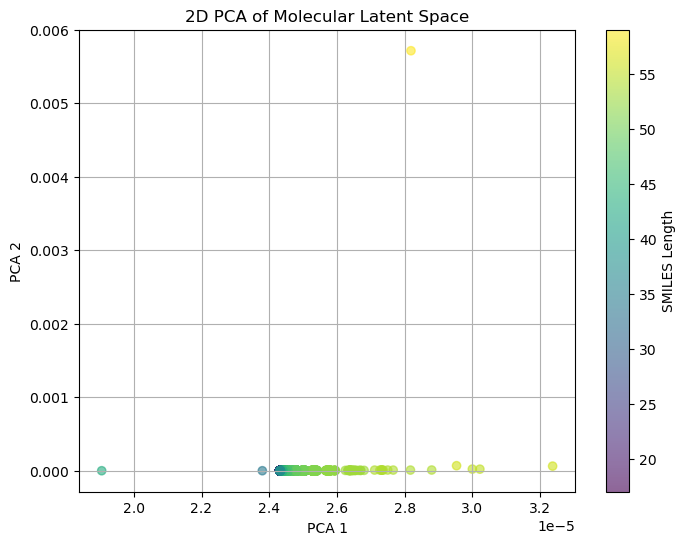

In [95]:
# Vislaize

import torch
from tqdm import tqdm

model.eval()
latents = []
labels = []  # optional — e.g., molecular weight, scaffold class, etc.

with torch.no_grad():
    for batch, in DataLoader(dataset, batch_size=64):
        batch = batch.to("mps")
        mu, logvar = model.encoder(batch)
        z = mu  # or reparameterize(mu, logvar)
        latents.append(z.cpu())
        # optionally add a property
        labels.extend([len(s[s != stoi['<pad>']]) for s in batch.cpu()])  # e.g., length of SMILES

latents = torch.cat(latents).numpy()

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
latents_2d = pca.fit_transform(latents)


import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], 
                      c=labels, cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label="SMILES Length" if labels else "")
plt.title("2D PCA of Molecular Latent Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.show()
